# Discriminator Model Benchmarking

The goal here is to find the best discriminator model for predicting disease associates gene (DaG) relationships. The few models tested in this are: bag of words, Doc2CecC 500k randomly sampled iterations, Doc2VecC all disease gene sentences, and a unidirectional long short term memory network (LSTM). The underlying hypothesis is that **The LSTM will be the best model in predicting DaG associations.**

## Set up The Environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
from itertools import product
import pickle
import os
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import LabelAnnotator
from snorkel.learning.structure import DependencySelector
from snorkel.learning.pytorch.rnn import LSTM
from snorkel.models import candidate_subclass, Candidate

from utils.label_functions import DG_LFS

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.doc2vec_helper import get_candidate_objects, execute_doc2vec, write_sentences_to_file 
from utils.notebook_utils.label_matrix_helper import label_candidates, make_cids_query, get_auc_significant_stats
from utils.notebook_utils.train_model_helper import train_generative_model, run_grid_search
from utils.notebook_utils.plot_helper import plot_curve

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
quick_load = True

# Get Estimated Training Labels

From the work in the [previous notebook](gen_model_benchmarking.ipynb), we determined that the best parameters for the generative model are: 0.4 reg_param, 100 burnin interations and 100 epochs for training. Using this information, we trained the generative model to get the estimated training labels show in the historgram below.

In [6]:
spreadsheet_names = {
    'train': '../../sentence_labels_train.xlsx',
    'dev': '../../sentence_labels_train_dev.xlsx',
    'test': '../../sentence_labels_dev.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 50000
Size of dev set: 60
Size of test set: 210


In [8]:
label_functions = (
    list(DG_LFS["DaG_DB"].values()) + 
    list(DG_LFS["DaG_TEXT"].values())
) 

if quick_load:
    labeler = LabelAnnotator(lfs=[])

    label_matricies = {
        key:labeler.load_matrix(session, cids_query=make_cids_query(session, candidate_dfs[key]))
        for key in candidate_dfs
    }

else:
    labeler = LabelAnnotator(lfs=label_functions)

    label_matricies = {
        key:label_candidates(
            labeler, 
            cids_query=make_cids_query(session, candidate_dfs[key]),
            label_functions=label_functions,
            apply_existing=(key!='train')
        )
        for key in candidate_dfs
    }

In [10]:
gen_model = train_generative_model(
        label_matricies['train'],
        burn_in=100,
        epochs=100,
        reg_param=0.401,
        step_size=1/label_matricies['train'].shape[0],
        deps=DependencySelector().select(label_matricies['train']),
        lf_propensity=True
    )
training_prob_labels = gen_model.marginals(label_matricies['train'])
training_labels = list(map(lambda x: 1 if x > 0.5 else 0, training_prob_labels))

Inferred cardinality: 2


(array([  8217.,   5883.,   3482.,   1530.,   1851.,    971.,   3814.,
          2197.,   6473.,  15582.]),
 array([  2.23059322e-04,   1.00200591e-01,   2.00178122e-01,
          3.00155653e-01,   4.00133184e-01,   5.00110715e-01,
          6.00088247e-01,   7.00065778e-01,   8.00043309e-01,
          9.00020840e-01,   9.99998372e-01]),
 <a list of 10 Patch objects>)

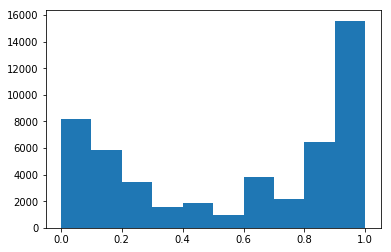

In [11]:
import matplotlib.pyplot as plt
plt.hist(training_prob_labels)

Based on this graph more than half of the data is receiving a positive label. Hard to tell if this is correct; however, based on some prior experience this seems to be incorrectly skewed towards the positive side. 

## Discriminator Models

As mentioned above here we train various discriminator models to determine which model can best predict DaG sentences through noisy labels.

### Bag of Words Model

In [12]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(
    candidate_dfs['train'].sentence.values
)
dev_X = vectorizer.transform(candidate_dfs['dev'].sentence.values)
test_X = vectorizer.transform(candidate_dfs['test'].sentence.values)

In [15]:
bow_model = run_grid_search(LogisticRegression(), X,  {'C':pd.np.linspace(1e-6,5, num=20)}, training_labels)

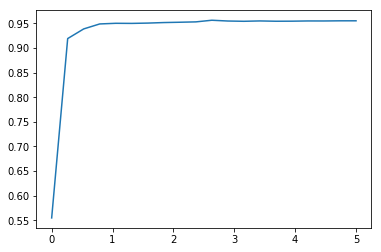

In [16]:
plt.plot(pd.np.linspace(1e-6,5, num=20), bow_model.cv_results_['mean_train_score'])

### Doc2VecC

This model comes from this [paper](https://arxiv.org/pdf/1707.02377.pdf), which is builds off of popular sentence/document embedding algorithms. Through their use of corruption, which involves removing words from a document to generate embeddings, the authors were able to achieve significant speed boosts and results. 
Majority of the steps to embed these sentences are located in this script [here](../../generate_doc2vec_sentences.py). Shown below are results after feeding these embeddings into the logistic regression algorithm. 

#### Doc2VecC 500k Subsample Experiment

In [27]:
files = zip(
    glob.glob('../../doc2vec/doc_vectors/500k_random_sample/train/train_doc_vectors_500k_subset_*.txt.xz'),
    glob.glob('../../doc2vec/doc_vectors/500k_random_sample/dev/dev_doc_vectors_500k_subset_*.txt.xz'),
    glob.glob('../../doc2vec/doc_vectors/500k_random_sample/test/test_doc_vectors_500k_subset_*.txt.xz')
)

doc2vec_500k_dev_marginals_df = pd.DataFrame()
doc2vec_500k_test_marginals_df = pd.DataFrame()

In [28]:
for index, data in tqdm_notebook(enumerate(files)):
    doc2vec_train = pd.read_table(data[0], header=None, sep=" ")
    doc2vec_train = doc2vec_train.values[:-1, :-1]
    
    doc2vec_dev = pd.read_table(data[1], header=None, sep=" ")
    doc2vec_dev = doc2vec_dev.values[:-1, :-1]
    
    doc2vec_test = pd.read_table(data[2], header=None, sep=" ")
    doc2vec_test = doc2vec_test.values[:-1, :-1]
    
    model = run_grid_search(LogisticRegression(), doc2vec_train,  
                            {'C':pd.np.linspace(1e-6, 5, num=4)}, training_labels)

    doc2vec_500k_dev_marginals_df['subset_{}'.format(index)] = model.predict_proba(doc2vec_dev)[:,1]
    doc2vec_500k_test_marginals_df['subset_{}'.format(index)] = model.predict_proba(doc2vec_test)[:,1]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

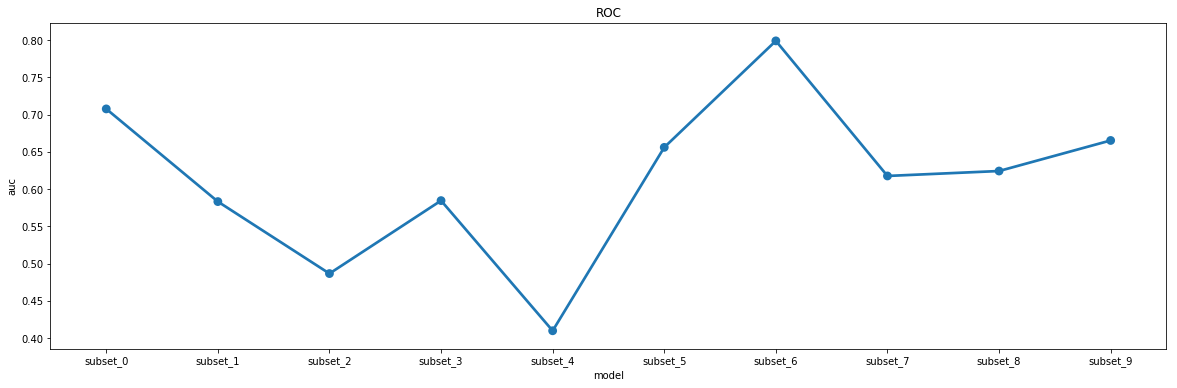

In [29]:
model_aucs=plot_curve(doc2vec_500k_dev_marginals_df, candidate_dfs['dev'].curated_dsh,
                      figsize=(20,6), model_type="scatterplot")

In [34]:
doc2vec_subset_df = pd.DataFrame.from_dict(model_aucs, orient='index')
doc2vec_subset_df.describe()

,0
count,10.000000
mean,0.613492
std,0.109080
min,0.410053
25%,0.583664
50%,0.621032
75%,0.663029
max,0.798942


#### Doc2Vec All D-G Sentences

In [31]:
doc2vec_X_all_DG = pd.read_table("../../doc2vec/doc_vectors/train_doc_vectors_all_dg.txt.xz",
                                 header=None, sep=" ")
doc2vec_X_all_DG = doc2vec_X_all_DG.values[:-1,:-1]

doc2vec_dev_X_all_DG = pd.read_table("../../doc2vec/doc_vectors/dev_doc_vectors_all_dg.txt.xz",
                                     header=None, sep=" ")
doc2vec_dev_X_all_DG = doc2vec_dev_X_all_DG.values[:-1,:-1]

doc2vec_test_X_all_DG = pd.read_table("../../doc2vec/doc_vectors/test_doc_vectors_all_dg.txt.xz",
                                      header=None, sep=" ")
doc2vec_test_X_all_DG = doc2vec_test_X_all_DG.values[:-1,:-1]

In [32]:
doc2vec_all_pubmed_model = run_grid_search(LogisticRegression(), doc2vec_X_all_DG,  
                                           {'C':pd.np.linspace(1e-6, 1, num=20)}, training_labels)

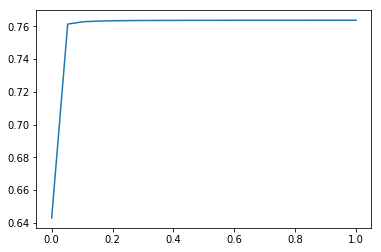

In [33]:
plt.plot(pd.np.linspace(1e-6, 1, num=20), doc2vec_all_pubmed_model.cv_results_['mean_train_score'])

### LSTM 

Here is the LSTM network uses the pytorch library. Because of the needed calculations, this whole sections gets ported onto penn's gpu cluster. Utilizing about 4 gpus this network takes less than a few hours to run depending on the embedding size.

#### Train LSTM on GPU

In [ ]:
lstm = LSTM()
cand_objs = get_candidate_objects(session, candidate_dfs)
X = lstm.preprocess_data(cand_objs['train'], extend=True)
dev_X = lstm.preprocess_data(cand_objs['dev'], extend=False)
test_X = lstm.preprocess_data(cand_objs['test'], extend=False)

In [ ]:
pickle.dump(X, open('../../lstm_cluster/train_matrix.pkl', 'wb'))
pickle.dump(X, open('../../lstm_cluster/dev_matrix.pkl', 'wb'))
pickle.dump(X, open('../../lstm_cluster/test_matrix.pkl', 'wb'))
pickle.dump(lstm, open('../../lstm_cluster/model.pkl', 'wb'))
pickle.dump(training_labels, open('../../lstm_cluster/train_labels.pkl', 'wb'))
pickle.dump(candidate_dfs['dev'].curated_dsh.astype(int).tolist(), open('../../lstm_cluster/dev_labels.pkl', 'wb'))

### Look at LSTM Results

In [35]:
dev_marginals = pickle.load(open('../../lstm_cluster/dev_lstm_marginals.pkl', 'rb'))
test_marginals = pickle.load(open('../../lstm_cluster/test_lstm_marginals.pkl', 'rb'))

In [36]:
lstm_dev_marginals_df = pd.DataFrame.from_dict(dev_marginals)
lstm_test_marginals_df = pd.DataFrame.from_dict(test_marginals)

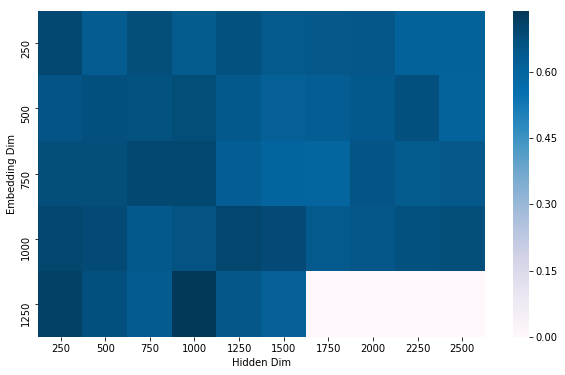

In [37]:
model_aucs = plot_curve(lstm_dev_marginals_df, candidate_dfs['dev'].curated_dsh, model_type='heatmap',
                           y_label="Embedding Dim", x_label="Hidden Dim", metric="ROC")

In [38]:
ci_auc_stats_df = get_auc_significant_stats(candidate_dfs['dev'], model_aucs).sort_values('auroc', ascending=False)
ci_auc_stats_df

mu: 378.000000, sigma: 61.991935


,auroc,u,z_u,p_value
"1250,1000",0.738095,558.0,2.903604,0.001844
"1250,250",0.711640,538.0,2.580981,0.004926
"1000,1250",0.695767,526.0,2.387407,0.008484
"1000,250",0.695767,526.0,2.387407,0.008484
"750,750",0.694444,525.0,2.371276,0.008863
"750,1000",0.694444,525.0,2.371276,0.008863
"250,250",0.693122,524.0,2.355145,0.009258
"1000,500",0.683862,517.0,2.242227,0.012473
"1000,1500",0.683862,517.0,2.242227,0.012473
"500,1000",0.679894,514.0,2.193834,0.014124


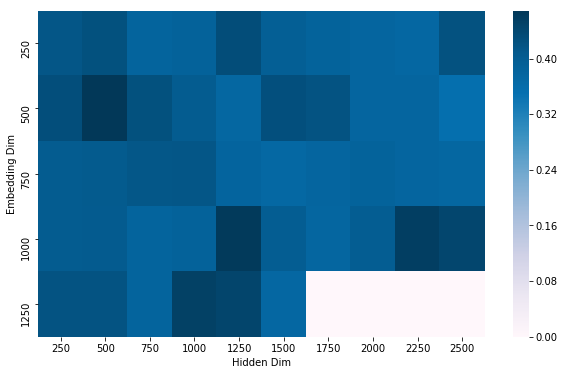

In [39]:
model_aucs = plot_curve(lstm_dev_marginals_df, candidate_dfs['dev'].curated_dsh, model_type='heatmap',
                           y_label="Embedding Dim", x_label="Hidden Dim", metric="PR")

### Let's see how the models compare with each other

In [47]:
dev_marginals_df = pd.DataFrame(
    pd.np.array([
        gen_model.marginals(label_matricies['dev']),
        bow_model.predict_proba(dev_X)[:,1], 
        doc2vec_500k_dev_marginals_df['subset_6'],
        doc2vec_all_pubmed_model.predict_proba(doc2vec_dev_X_all_DG)[:,1],
        lstm_dev_marginals_df['1250,1000'].tolist()
    ]).T, 
    columns=['Gen_Model', 'Bag_of_Words', 'Doc2Vec 500k', 'Doc2Vec All DG', 'LSTM']
)
dev_marginals_df.head(2)

,Gen_Model,Bag_of_Words,Doc2Vec 500k,Doc2Vec All DG,LSTM
0,0.928628,0.446128,0.459141,0.452220,0.811478
1,0.998287,0.928191,0.564950,0.699083,0.998257


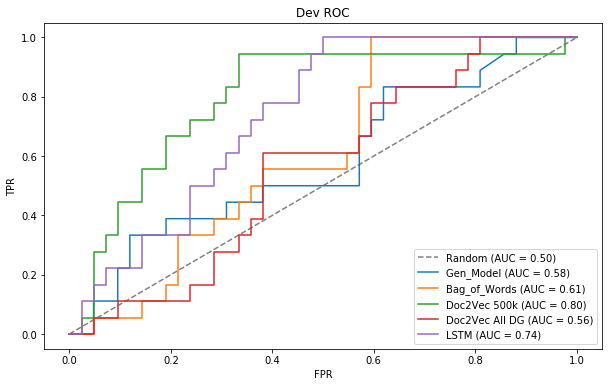

In [48]:
model_aucs = plot_curve(
    dev_marginals_df, candidate_dfs['dev'].curated_dsh, 
    plot_title="Dev ROC", model_type='curve', 
    figsize=(10,6), metric="ROC"
)

In [42]:
get_auc_significant_stats(candidate_dfs['dev'], model_aucs)

mu: 378.000000, sigma: 61.991935


,auroc,u,z_u,p_value
Gen_Model,0.584656,442.0,1.032392,0.150944
Bag_of_Words,0.611111,462.0,1.355015,0.087706
Doc2Vec 500k,0.486772,368.0,-0.161311,0.564076
Doc2Vec All DG,0.559524,423.0,0.725901,0.233950
LSTM,0.738095,558.0,2.903604,0.001844


In [43]:
test_marginals_df = pd.DataFrame(
    pd.np.array([
        gen_model.marginals(label_matricies['test']),
        bow_model.best_estimator_.predict_proba(test_X)[:,1],
        doc2vec_500k_test_marginals_df['subset_6'],
        doc2vec_all_pubmed_model.best_estimator_.predict_proba(doc2vec_test_X_all_DG)[:,1],
        lstm_test_marginals_df['1250,1000'].tolist()
    ]).T, 
    columns=['Gen_Model', 'Bag_of_Words', 'Doc2Vec 500k', 'Doc2Vec All DG', 'LSTM']
)
test_marginals_df.head(2)

,Gen_Model,Bag_of_Words,Doc2Vec 500k,Doc2Vec All DG,LSTM
0,0.984119,0.990336,0.345290,0.713432,0.995710
1,0.846896,0.899538,0.758997,0.479744,0.928504


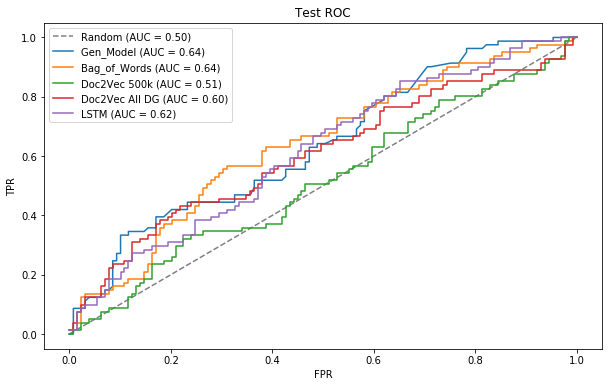

In [44]:
model_aucs = plot_curve(
    test_marginals_df, candidate_dfs['test'].curated_dsh, 
    plot_title="Test ROC", model_type='curve', 
    figsize=(10,6), metric="ROC"
)

In [45]:
get_auc_significant_stats(candidate_dfs['test'], model_aucs)

mu: 5224.500000, sigma: 428.635335


,auroc,u,z_u,p_value
Gen_Model,0.637621,6662.5,3.354833,0.000397
Bag_of_Words,0.636042,6646.0,3.316339,0.000456
Doc2Vec 500k,0.514595,5377.0,0.355780,0.361003
Doc2Vec All DG,0.603598,6307.0,2.525457,0.005777
LSTM,0.615178,6428.0,2.807748,0.002494


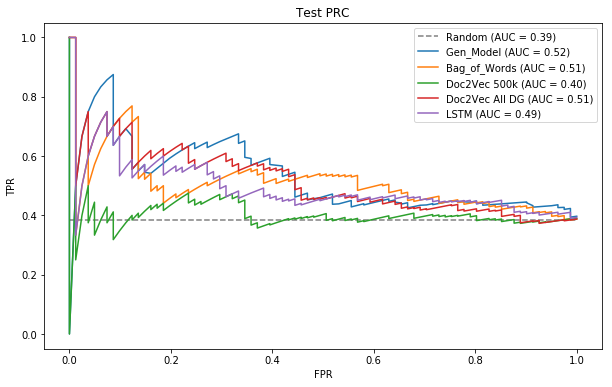

In [46]:
model_aucs = plot_curve(
    test_marginals_df, candidate_dfs['test'].curated_dsh, 
    plot_title="Test PRC", model_type='curve', 
    figsize=(10,6), metric="PR"
)